<a href="https://colab.research.google.com/github/HoangTung99/CS114.L11.KHCL/blob/master/NT006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Bài toán: Nhận diện cảm xúc qua gương mặt người**

**1. Mô tả bài toán**

Input: Một bức ảnh kích thước 48x48, đã gray scale, có chứa đúng 1 gương mặt người, gương mặt người phải có cảm xúc là 1 trong 6 loại sau (angry, fear, happy, sad, neutral, surprise)

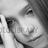

Ouput: Tên của 1 trong 6 loại cảm xúc (angry, fear, happy, sad, neutral, surprise)

Ví dụ: sad

**2. Mô tả bộ dữ liệu**

**Nguồn**: Google Image

Thu nhặt ảnh thể hiện cảm xúc của 1 khuôn mặt người từ nhiều nguồn thông qua Google Image với sự hỗ trợ của công cụ hỗ trợ chuẩn hoá ảnh: https://github.com/HoangTung99/CS114.L11.KHCL/blob/master/Face_Detection.ipynb

**Công cụ chuẩn hoá để hỗ trợ cho việc thu nhặt ảnh**
- Input: Một bức ảnh có ít nhất 1 gương mặt người
- Output: 1 cơ số tấm ảnh, với mỗi ảnh sẽ: Chứa đúng 1 gương mặt người, ảnh được gray scale và resize kích thước (48x48)


**Quá trình thu nhặt ảnh**
1. Tìm kiếm ảnh trên google image
2. Đưa ảnh vào công cụ chuẩn hoá
3. Chạy công cụ
4. Tiến hành kiểm tra từng tấm ảnh trả ra từ công cụ chuẩn hoá với cả 3 điều kiện sau ( cần kiểm tra lại để tránh sự sai sót của công cụ ):
    + Chứa đúng 1 gương mặt người
    + Đã gray scale
    + Đã resize kích thước 48x48
5. Tải những ảnh cho ra từ công cụ chuẩn hoá mà thoả mãn 3 điều kiện trên về máy
6. Tải lên folder DataSet_CS114 trên google drive theo đường link: https://drive.google.com/drive/folders/1kTAoBLJXEQaj9JOuLZD8xZbCx3I2clUM?usp=sharing

**Cấu trúc folder DataSet_CS114:**
- Gồm 3 thư mục chính:
  + train
  + validation
  + test
- Mỗi thư mục chính, sẽ bao gồm 6 thư mục con:
  + angry
  + fear
  + happy
  + sad
  + neutral
  + surprise

**Tổng số ảnh**: 9216


**Phân chia dữ liệu**:
- Train (60%): 1024 tấm ảnh cho từng loại cảm xúc
- Validation (20%): 256 tấm ảnh cho từng loại cảm xúc
- Test (20%): 256 tấm ảnh cho từng loại cảm xúc



**3. Mô tả về đặc trưng**

**4. Mô tả thuật toán máy học:**

Dùng model Sequential
Mô hình:
- 4 khối Convolution ( mỗi khối gồm)
  + 1 convolution2D layer để trích xuất đặc trưng
  + 1 batchNormalization layer để chuẩn hoá khối batch
  + 1 relu layer để khử tuyến tính
  + 1 MaxPooling2D để giữ lại đặc trưng quan trọng => giảm độ phức tạp bài toán
  + 1 dropout layer để khử bớt dữ liệu => giảm over-fitting
- 1 Flattern layer 
- 2 khối fully connected
- 1 Dense Layer với activation function là softmax


**5. Cài đặt, tinh chỉnh tham số**

Tiến hành thay đổi các tham số (learning rate, batch_size, epoch, số lượng ảnh):

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install utils
!pip install livelossplot

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
from livelossplot import PlotLossesKerasTF
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

In [ ]:
path_dir_data = "drive/MyDrive/Data_FaceRecognition/"
path_dir_data_train = "drive/MyDrive/Data_FaceRecognition/train/"
path_dir_data_validation = "drive/MyDrive/Data_FaceRecognition/validation/"
path_dir_data_test = "drive/MyDrive/Data_FaceRecognition/test/"

In [ ]:
for expression in os.listdir(path_dir_data_train):
    print(str(len(os.listdir(path_dir_data_train + expression))) + " " + expression + " images")

**Hyper params**

In [ ]:
batch_size = 64
numberOfEmotions = 6
learning_rate = 0.0005
min_learning_rate = 0.00001
epochs = 10

**Generate Training and Validation Batches**

In [ ]:
img_size = 48

datagen_train = ImageDataGenerator(horizontal_flip=True)
train_generator = datagen_train.flow_from_directory(path_dir_data_train,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

datagen_validation = ImageDataGenerator(horizontal_flip=True)
validation_generator = datagen_validation.flow_from_directory(path_dir_data_validation,
                                                    target_size=(img_size,img_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

**Create Model**

In [ ]:
## Bo sung source auth

# First model
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(img_size, img_size,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(numberOfEmotions, activation='softmax'))

opt = Adam(lr=learning_rate)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

#--------------------------------------------------------------------------
#--------------------------------------------------------------------------

# # Second Model
# model = Sequential()

# model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(img_size, img_size, 1)))
# model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
# model.add(Dropout(0.5))

# #2nd convolution layer
# model.add(Conv2D(64, (3, 3), activation='relu'))
# model.add(Conv2D(64, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))
# model.add(Dropout(0.5))

# #3rd convolution layer
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# # model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=(2, 2)))

# model.add(Flatten())

# #fully connected neural networks
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.2))

# model.add(Dense(numberOfEmotions, activation='softmax'))


# #Compliling the model
# model.compile(loss="categorical_crossentropy",
#               optimizer=Adam(),
#               metrics=['accuracy'])

# model.summary()

In [ ]:
epochs = 10
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=2, min_lr=min_learning_rate, mode='auto')

#--------------------------------------------------------------------------
#--------------------------------------------------------------------------

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
#                               patience=2, mode='auto')

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy',
                             save_weights_only=True, mode='max', verbose=1)
callbacks = [PlotLossesKerasTF(), checkpoint, reduce_lr]

history = model.fit(
    x=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks=callbacks
)

**Represent Model as JSON String**

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

**Testing & Rating**

In [ ]:
import os  
import numpy as np 
import cv2  
from PIL import Image
import matplotlib.pyplot as plt

 
from keras.models import model_from_json  
from keras.preprocessing import image 
from google.colab.patches import cv2_imshow

In [ ]:
#load model  
model = model_from_json(open("drive/MyDrive/Project/model.json", "r").read())  
#load weights  
model.load_weights('drive/MyDrive/Project/model_weights.h5')

In [ ]:
# Download pre-train model for detect faces
!curl -o haarcascade_frontalface_default.xml https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  908k  100  908k    0     0  2911k      0 --:--:-- --:--:-- --:--:-- 2911k


In [ ]:
# download photo
!curl -o test_img https://image.shutterstock.com/image-photo/sad-little-girl-pigtails-portrait-260nw-1269412360.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 14686  100 14686    0     0   131k      0 --:--:-- --:--:-- --:--:--  132k


In [ ]:
# # load photo
# test_img = cv2.imread("test_img")

# # convert photo to gray scale
# gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# # detect face
# classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# # perform face detection
# faces_detected = classifier.detectMultiScale(gray_img)

# for box in faces_detected:  
#   x,  y, h, w = box
#   cv2.rectangle(gray_img,(x,y),(x+w,y+h),(255,0,0),thickness=2) 
#   roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image  
#   roi_gray=cv2.resize(roi_gray,(48,48), interpolation = cv2.INTER_AREA)  
#   img_pixels = image.img_to_array(roi_gray)  
#   img_pixels = np.expand_dims(img_pixels, axis = 0)  
#   img_pixels /= 255  
  
#   print(type(roi_gray))
#   print(type(gray_img))
#   print(type(test_img))
#   predictions = model.predict(img_pixels)  

#   #find max indexed array  
#   max_index = np.argmax(predictions[0])  

#   emotions = ('angry', 'fear', 'happy', 'neutral', 'sad', 'surprise')  
#   predicted_emotion = emotions[max_index]  
#   text_size = 1
#   if h > 400:
#     text_size = 2
#   elif h > 800:
#     text_size = 3
#   cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,0,255), 2)
#   print(max_index)
  

# cv2_imshow(test_img)  


test_img = cv2.imread("sad_train_45.jpg")

gray_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

# roi_gray = gray_img[y: 48, x: 48]
# roi_gray = cv2.resize(roi_gray, (48, 48))

img_pixels = image.img_to_array(gray_img)  
img_pixels = np.expand_dims(img_pixels, axis = 0)  
img_pixels /= 255  

predictions = model.predict(img_pixels)

#find max indexed array  
max_index = np.argmax(predictions[0])  

emotions = ('angry', 'fear', 'happy', 'neutral', 'sad', 'surprise')  
predicted_emotion = emotions[max_index]  

print(predicted_emotion)

surprise


In [ ]:
# emotions = []
# for expression in os.listdir(path_dir_data_train + "angry"):
#     img_path = str(path_dir_data_train + "angry" + expression)
#     img_pred = cv2.imread(img_path)
#     img_pred = cv2.resize(img_pred,(48,48), interpolation = cv2.INTER_AREA)  
#     img_pred_pixels = image.img_to_array(img_pred)  
#     img_pred_pixels = np.expand_dims(img_pred_pixels, axis = 0)  
#     img_pred_pixels /= 255  

#     preds = model.predict(img_pred_pixels)

#     #find max indexed array  
#     max_index = np.argmax(predictions[0])  

#     emotions = ('angry', 'fear', 'happy', 'neutral', 'sad', 'surprise')  
#     predicted_emotion = emotions[max_index] 
#     emotions.append(predicted_emotion)
i = cv2.imread(r"drive/MyDrive/DataSet_CS114/train/angryTraining_25739285.jpg")
cv2_imshow(i)